In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
data_name = 'ev_charging_patterns.csv'
data = pd.read_csv(data_name)
data = data.dropna()
data[:10]

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.000000,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.000000,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.000000,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.000000,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.000000,Level 1,Long-Distance Traveler
5,User_6,Nissan Leaf,50.000000,Station_335,San Francisco,2024-01-01 05:00:00,2024-01-01 07:10:00,43.181137,1.167640,14.334523,36.900341,Evening,Saturday,75.217748,71.982288,143.680046,-5.274218,0.000000,DC Fast Charger,Long-Distance Traveler
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,22.214225,Evening,Friday,60.751781,70.796097,81.338009,27.551335,4.000000,Level 2,Commuter
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,9.796821,Afternoon,Monday,56.201703,63.786815,116.543166,-4.417460,0.000000,Level 2,Long-Distance Traveler
8,User_9,Chevy Bolt,62.000000,Station_493,Los Angeles,2024-01-01 08:00:00,2024-01-01 09:21:00,43.592372,1.724204,14.294923,32.465005,Evening,Wednesday,33.466200,92.961421,208.259742,22.516706,4.000000,Level 1,Commuter
9,User_10,Hyundai Kona,50.000000,Station_452,Chicago,2024-01-01 09:00:00,2024-01-01 12:44:00,78.868607,2.026875,11.761000,21.312302,Morning,Wednesday,27.399455,70.053381,54.006309,27.512019,2.830381,DC Fast Charger,Commuter


In [3]:
dist_models = data['Vehicle Model'].value_counts()
dist_models

Tesla Model 3    244
Nissan Leaf      227
BMW i3           223
Chevy Bolt       219
Hyundai Kona     218
Name: Vehicle Model, dtype: int64

In [4]:
dist_charging_loc = data['Charging Station Location'].value_counts()
dist_charging_loc

Los Angeles      250
Houston          229
San Francisco    221
New York         220
Chicago          211
Name: Charging Station Location, dtype: int64

In [5]:
unique_chargers = data['Charging Station ID'].value_counts()
unique_chargers

Station_108    8
Station_461    7
Station_17     7
Station_10     6
Station_433    6
              ..
Station_33     1
Station_75     1
Station_320    1
Station_86     1
Station_374    1
Name: Charging Station ID, Length: 446, dtype: int64

In [6]:
temperature_readings_C = data['Temperature (°C)'].value_counts()
temperature_readings_F = data['Temperature (°C)']* 9/5 +32

temperature_readings_F.value_counts()

82.306316    1
75.442044    1
36.048299    1
31.108862    1
62.515570    1
            ..
28.913944    1
18.497456    1
88.914815    1
62.557108    1
19.460133    1
Name: Temperature (°C), Length: 1131, dtype: int64

In [40]:
locaiton_temperatures = data.groupby('Charging Station Location')['Temperature (°C)'].apply(lambda temps: [t* 9/5 + 32 for t in temps])
locaiton_temperatures

Charging Station Location
Chicago          [81.52163485632666, 65.13027629046685, 103.926...
Houston          [82.3063155004417, 100.9693636886542, 81.59240...
Los Angeles      [17.898441750951417, 24.048572601285084, 72.53...
New York         [39.94759331384083, 99.374641758059, 38.445511...
San Francisco    [57.759846188680015, 69.80360330505958, 22.506...
Name: Temperature (°C), dtype: object

In [41]:
locaiton_temperatures_var = data.groupby('Charging Station Location')['Temperature (°C)'].apply(lambda temps: np.var([t* 9/5 + 32 for t in temps])) 
locaiton_temperatures_var

Charging Station Location
Chicago          701.558315
Houston          691.936973
Los Angeles      681.271915
New York         734.671224
San Francisco    689.067949
Name: Temperature (°C), dtype: float64

compares the min,mean, max of each cities temp

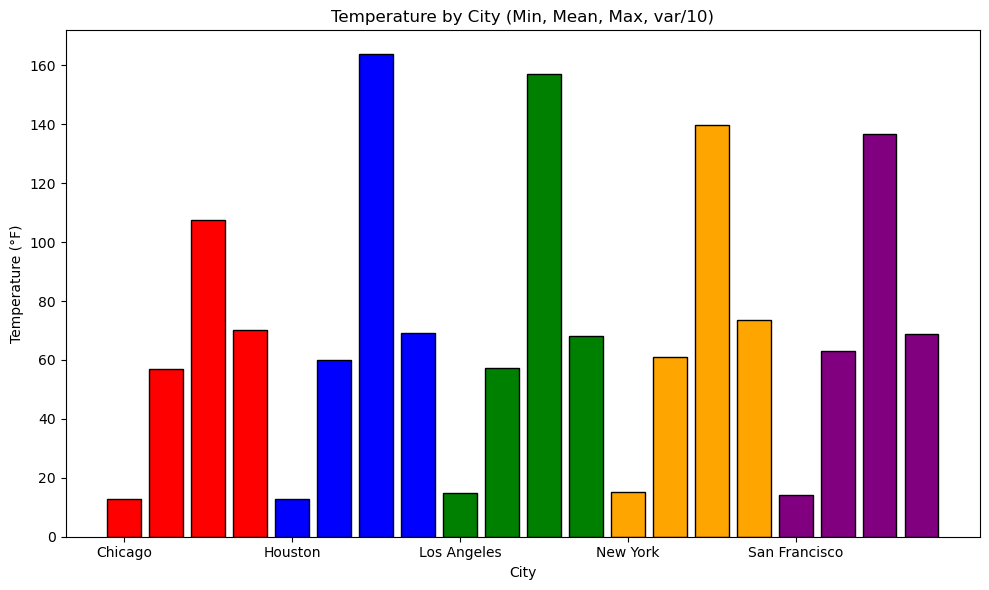

In [46]:
compare_charging_data = []
cities = list(locaiton_temperatures.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = locaiton_temperatures[city]
    var = locaiton_temperatures_var[city]
    compare_charging_data.extend([min(rates), np.mean(rates), max(rates), var/10])
    city_labels.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Temperature by City (Min, Mean, Max, Var/10)')
plt.xlabel('City')
plt.ylabel('Temperature (°F)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

In [9]:
encoded_location_temp = data.groupby('Charging Station Location')['Temperature (°C)'].apply(
    lambda temps: temps.apply(lambda t: 'Hot' if t > 30 else ('Normal' if t > 15 else 'Cold')).tolist()
)

encoded_location_temp

Charging Station Location
Chicago          [Normal, Normal, Hot, Cold, Cold, Hot, Normal,...
Houston          [Normal, Hot, Normal, Hot, Hot, Hot, Normal, C...
Los Angeles      [Cold, Cold, Normal, Cold, Cold, Cold, Hot, Co...
New York         [Cold, Hot, Cold, Hot, Hot, Hot, Cold, Cold, H...
San Francisco    [Cold, Normal, Cold, Hot, Normal, Normal, Cold...
Name: Temperature (°C), dtype: object

In [10]:
for city in list(encoded_location_temp.keys()):
    print(city)
    print(pd.Series(encoded_location_temp[city]).value_counts())

Chicago
Cold      116
Normal     58
Hot        37
dtype: int64
Houston
Cold      114
Normal     74
Hot        41
dtype: int64
Los Angeles
Cold      136
Normal     69
Hot        45
dtype: int64
New York
Cold      105
Normal     62
Hot        53
dtype: int64
San Francisco
Cold      99
Normal    66
Hot       56
dtype: int64


In [11]:
locaiton_charging_rates = data.groupby('Charging Station Location')['Charging Rate (kW)'].apply(lambda temps: [t* 9/5 + 32 for t in temps])
locaiton_charging_rates

Charging Station Location
Chicago          [53.16979948728262, 43.90570422454315, 66.5507...
Houston          [97.50052502056653, 91.1891655632952, 79.13333...
Los Angeles      [50.388281728168295, 80.06523397795075, 57.730...
New York         [120.92492950820558, 68.8835228827526, 121.478...
San Francisco    [87.219922891486, 81.52446660579183, 57.802140...
Name: Charging Rate (kW), dtype: object

Generates Graphs of a given city and its charging rate

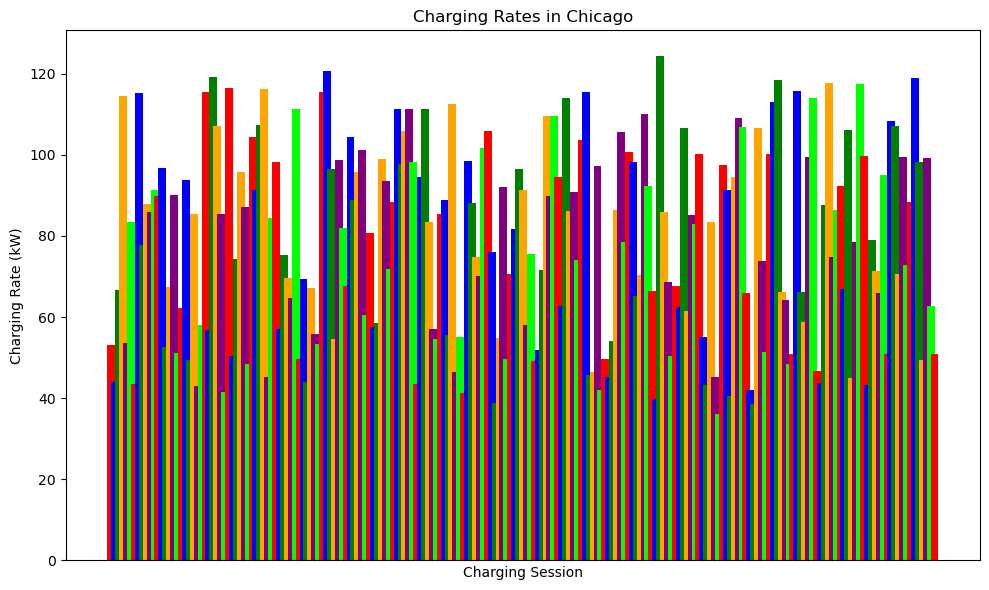

In [ ]:
loc = 'Chicago'
charging_data = locaiton_charging_rates[loc]

# Define colors and cycle through them
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']
bar_colors = [colors[i % len(colors)] for i in range(len(charging_data))]


plt.figure(figsize=(10, 6))
# Plot with thicker bars that touch and alternate colors
plt.bar(range(len(charging_data)), charging_data, color=bar_colors, width=2)
plt.title(f'Charging Rates in {loc}')
plt.xlabel('Charging Stations')
plt.ylabel('Charging Rate (kW)')
plt.xticks([])
plt.tight_layout()

# Display the plot
plt.show()

Generates a bar graph comparing the mean, low, and high of each city

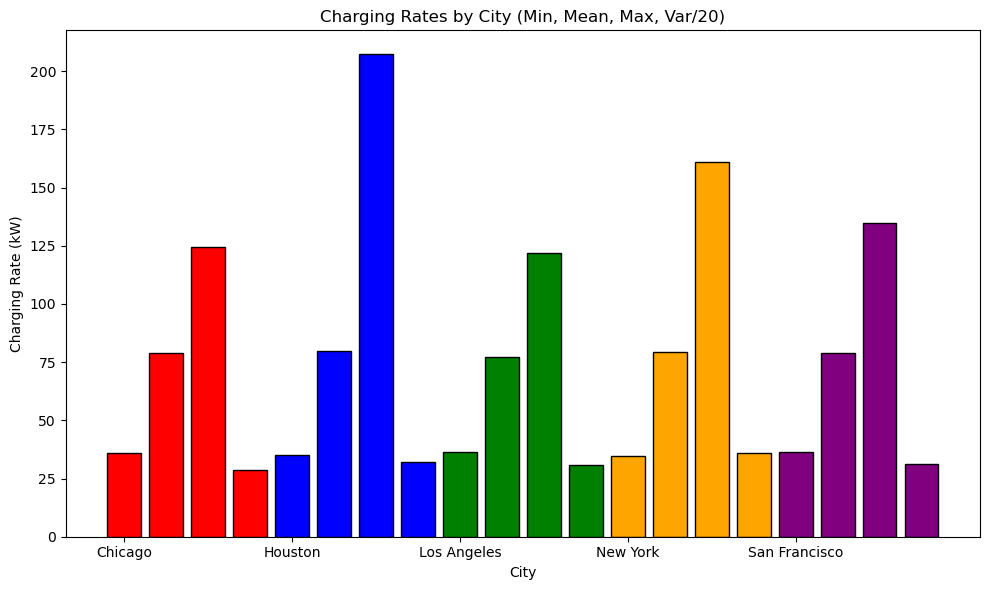

In [48]:
compare_charging_data = []
cities = list(locaiton_charging_rates.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = locaiton_charging_rates[city]
    var = np.var(rates)/20
    compare_charging_data.extend([min(rates), np.mean(rates), max(rates), var])
    city_labels.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Charging Rates by City (Min, Mean, Max, Var/20)')
plt.xlabel('City')
plt.ylabel('Charging Rate (kW)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

In [14]:
locaiton_charger_types = data.groupby('Charging Station Location')['Charger Type'].apply(list)
locaiton_charger_types

Charging Station Location
Chicago          [DC Fast Charger, Level 2, DC Fast Charger, DC...
Houston          [DC Fast Charger, Level 1, Level 2, Level 2, L...
Los Angeles      [Level 1, Level 2, Level 1, DC Fast Charger, D...
New York         [DC Fast Charger, Level 1, DC Fast Charger, Le...
San Francisco    [Level 1, Level 2, DC Fast Charger, DC Fast Ch...
Name: Charger Type, dtype: object

Generates a bar graph of each charger type in each city

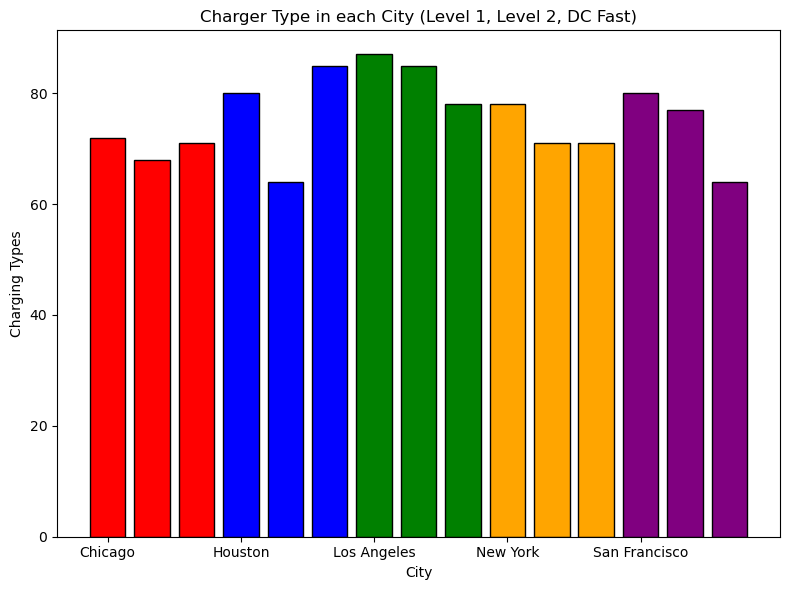

In [15]:
compare_charging_data = []
cities = list(locaiton_charger_types.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = locaiton_charger_types[city]
    vals = Counter(rates)
    compare_charging_data.extend([vals['Level 1'], vals['Level 2'], vals['DC Fast Charger']])
    city_labels.extend([city] * 3)

plt.figure(figsize=(8, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 3: (i + 1) * 3]
    plt.bar(city_position, compare_charging_data[i * 3:(i + 1) * 3], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Charger Type in each City (Level 1, Level 2, DC Fast)')
plt.xlabel('City')
plt.ylabel('Charging Types')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 3), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

Generates a pie graph for each city's charger type distrbution

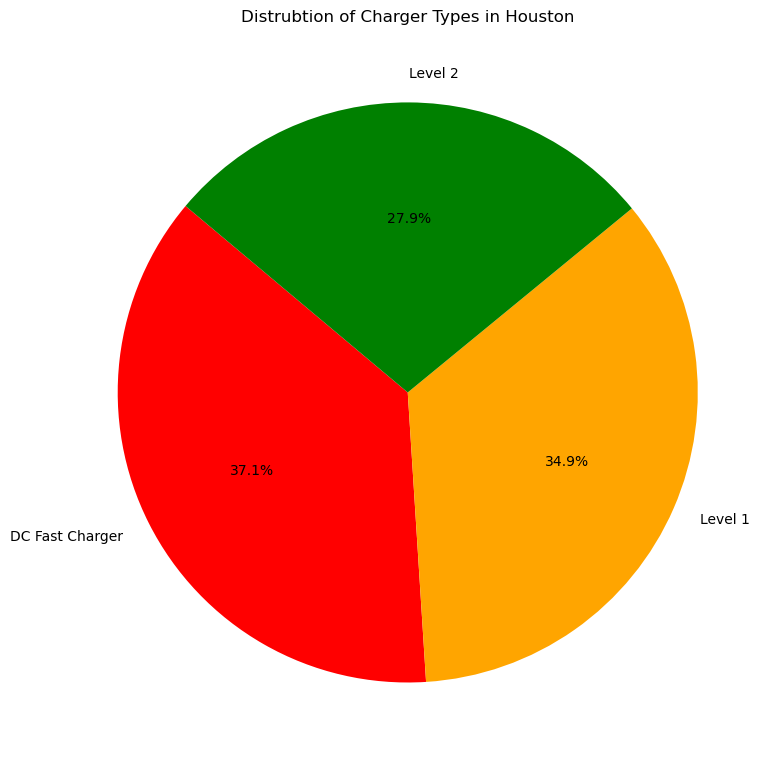

In [16]:
loc = 'Houston'
t_o_d = locaiton_charger_types[loc]
d = Counter(t_o_d)

colors = ['red', 'orange', 'green']
labels = d.keys()
sizes = d.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)


plt.title(f'Distrubtion of Charger Types in {loc}')
plt.tight_layout()

plt.show()

In [17]:
locaiton_charger_types_rates = data.groupby(['Charging Station Location', 'Charger Type'])['Charging Rate (kW)'].apply(list)
locaiton_charger_types_rates

Charging Station Location  Charger Type   
Chicago                    DC Fast Charger    [11.76099971515701, 19.194882837079632, 45.811...
                           Level 1            [12.064391459035129, 32.95451081519971, 10.621...
                           Level 2            [6.614280124746195, 6.35266144526304, 46.27844...
Houston                    DC Fast Charger    [36.3891805669814, 4.48564710517362, 34.458241...
                           Level 1            [32.882869757386224, 24.21115011711917, 11.238...
                           Level 2            [26.18518786003352, 19.76909871755716, 7.65157...
Los Angeles                DC Fast Charger    [10.310701112892176, 11.112498841670842, 16.91...
                           Level 1            [10.215712071204608, 14.294922926661108, 13.17...
                           Level 2            [26.7029077655282, 45.29143534649799, 30.48996...
New York                   DC Fast Charger    [49.40273861566977, 49.71030696901287, 38.4508.

Generates a bar graph for each charging rate per charger type in a city

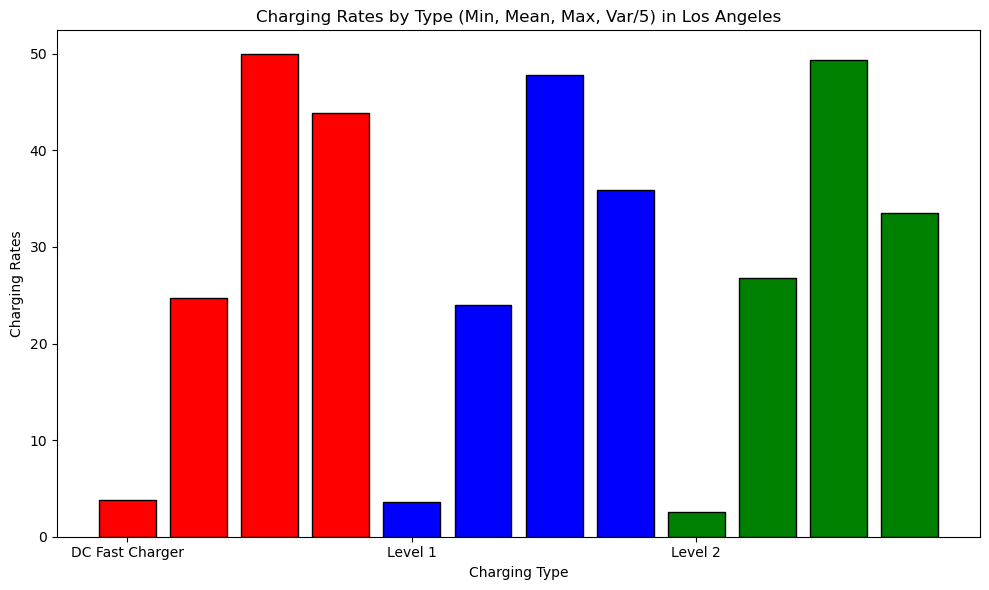

In [50]:
loc = 'Los Angeles'
compare_charging_data = []
charging_rates = list(locaiton_charger_types_rates[loc].keys())
types = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(charging_rates):
    rates = locaiton_charger_types_rates[loc][city]
    var = np.var(rates)/5
    compare_charging_data.extend([min(rates), np.mean(rates), max(rates), var])
    types.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title(f'Charging Rates by Type (Min, Mean, Max, Var/5) in {loc}')
plt.xlabel('Charging Type')
plt.ylabel('Charging Rates')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=charging_rates, rotation=0)
plt.tight_layout()
plt.show()

In [19]:
locaiton_charger_types_costs = data.groupby(['Charging Station Location', 'Charger Type'])['Charging Cost (USD)'].apply(list)
locaiton_charger_types_costs

Charging Station Location  Charger Type   
Chicago                    DC Fast Charger    [21.312302451155745, 14.856131218606723, 33.13...
                           Level 1            [17.011782945517666, 18.02550998683417, 34.760...
                           Level 2            [6.430589211997161, 18.131831711875755, 18.849...
Houston                    DC Fast Charger    [13.087716791774506, 35.50300017025295, 9.7984...
                           Level 1            [13.036238833914622, 18.552815677456245, 24.03...
                           Level 2            [22.21422517569784, 37.44185660286842, 18.0343...
Los Angeles                DC Fast Charger    [38.221230704051806, 33.093492711055774, 10.60...
                           Level 1            [10.161471171031415, 32.465005072088225, 28.10...
                           Level 2            [9.796821321322032, 7.090844200594135, 28.8728...
New York                   DC Fast Charger    [17.49480846107398, 38.40606169605943, 15.8827.

Generates a bar graph for a city on the cost of charging using a charger type

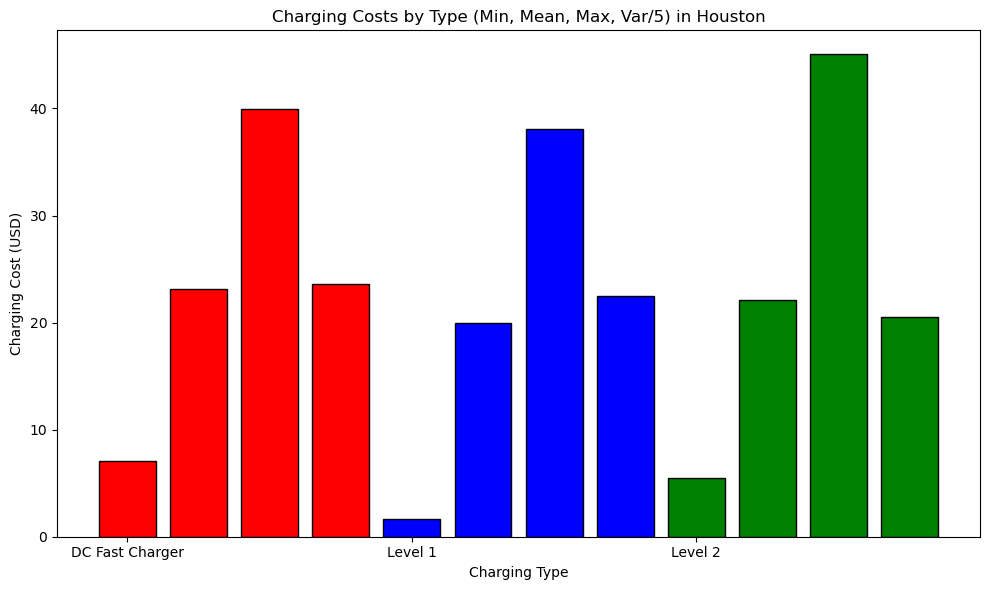

In [52]:
loc = 'Houston'
compare_charging_data = []
charging_rates = list(locaiton_charger_types_costs[loc].keys())
types = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(charging_rates):
    rates = locaiton_charger_types_costs[loc][city]
    var = np.var(rates)/5
    compare_charging_data.extend([min(rates), np.mean(rates), max(rates), var])
    types.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title(f'Charging Costs by Type (Min, Mean, Max, Var/5) in {loc}')
plt.xlabel('Charging Type')
plt.ylabel('Charging Cost (USD)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=charging_rates, rotation=0)
plt.tight_layout()
plt.show()

In [21]:
locaiton_time_of_day = data.groupby('Charging Station Location')['Time of Day'].apply(list)
locaiton_time_of_day

Charging Station Location
Chicago          [Morning, Evening, Afternoon, Afternoon, Eveni...
Houston          [Evening, Evening, Evening, Morning, Afternoon...
Los Angeles      [Morning, Afternoon, Evening, Night, Evening, ...
New York         [Evening, Evening, Morning, Evening, Evening, ...
San Francisco    [Morning, Morning, Evening, Evening, Afternoon...
Name: Time of Day, dtype: object

Generates the time of day distrubtion pie graph for a given city

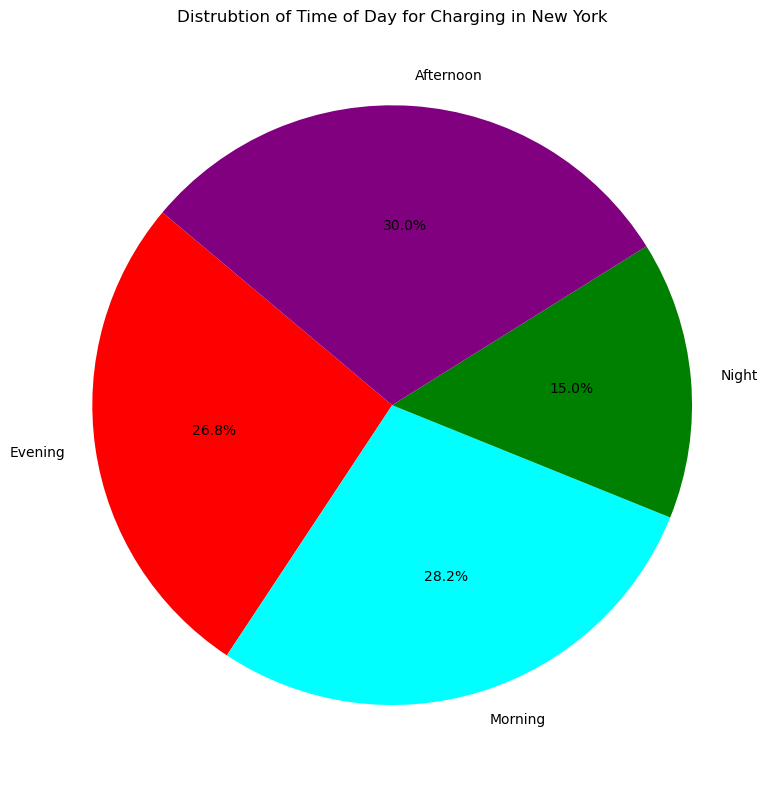

In [22]:
loc = 'New York'
t_o_d = locaiton_time_of_day[loc]
d = Counter(t_o_d)

colors = ['red', 'cyan', 'green', 'purple']
labels = d.keys()
sizes = d.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)


plt.title(f'Distrubtion of Time of Day for Charging in {loc}')
plt.tight_layout()

plt.show()

In [23]:
locaiton_day_of_week = data.groupby('Charging Station Location')['Day of Week'].apply(list)
locaiton_day_of_week

Charging Station Location
Chicago          [Wednesday, Friday, Saturday, Friday, Wednesda...
Houston          [Tuesday, Saturday, Friday, Friday, Monday, We...
Los Angeles      [Saturday, Monday, Wednesday, Thursday, Monday...
New York         [Thursday, Saturday, Friday, Monday, Tuesday, ...
San Francisco    [Monday, Thursday, Saturday, Sunday, Monday, S...
Name: Day of Week, dtype: object

Generates a pie graph for day of weeks where charing occurs


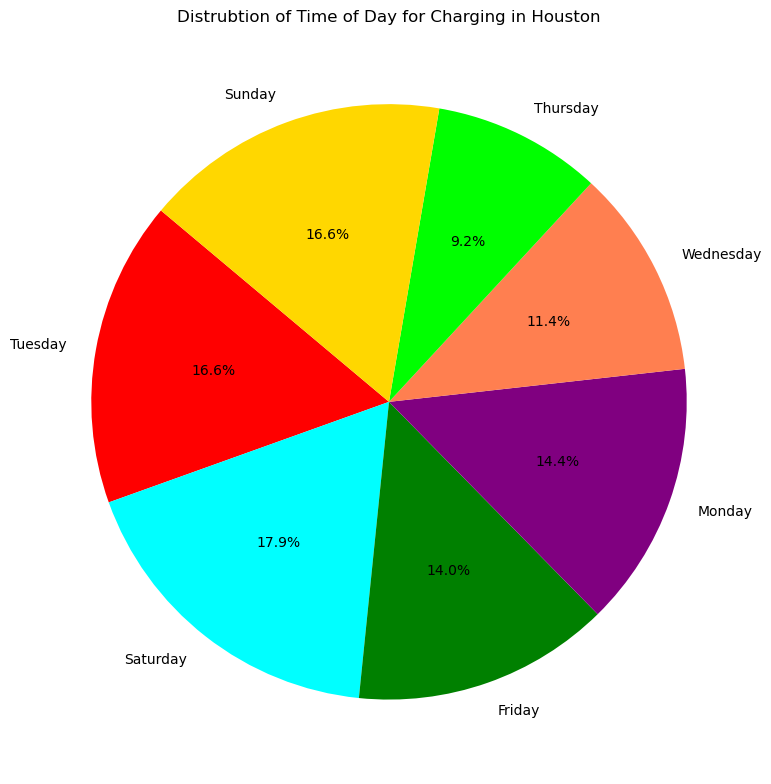

In [24]:
loc = 'Houston'
t_o_d = locaiton_day_of_week[loc]
d = Counter(t_o_d)
# Define colors and cycle through them
colors = ['red', 'cyan', 'green', 'purple', 'coral', 'lime', 'gold']
labels = d.keys()
sizes = d.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Title and layout
plt.title(f'Distrubtion of Time of Day for Charging in {loc}')
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
# vehicle age and locaiton
# vehicle battery start and end time based on location
# coe matrix for 

In [26]:
d = data['User Type']
d.value_counts()

Commuter                  404
Long-Distance Traveler    381
Casual Driver             346
Name: User Type, dtype: int64

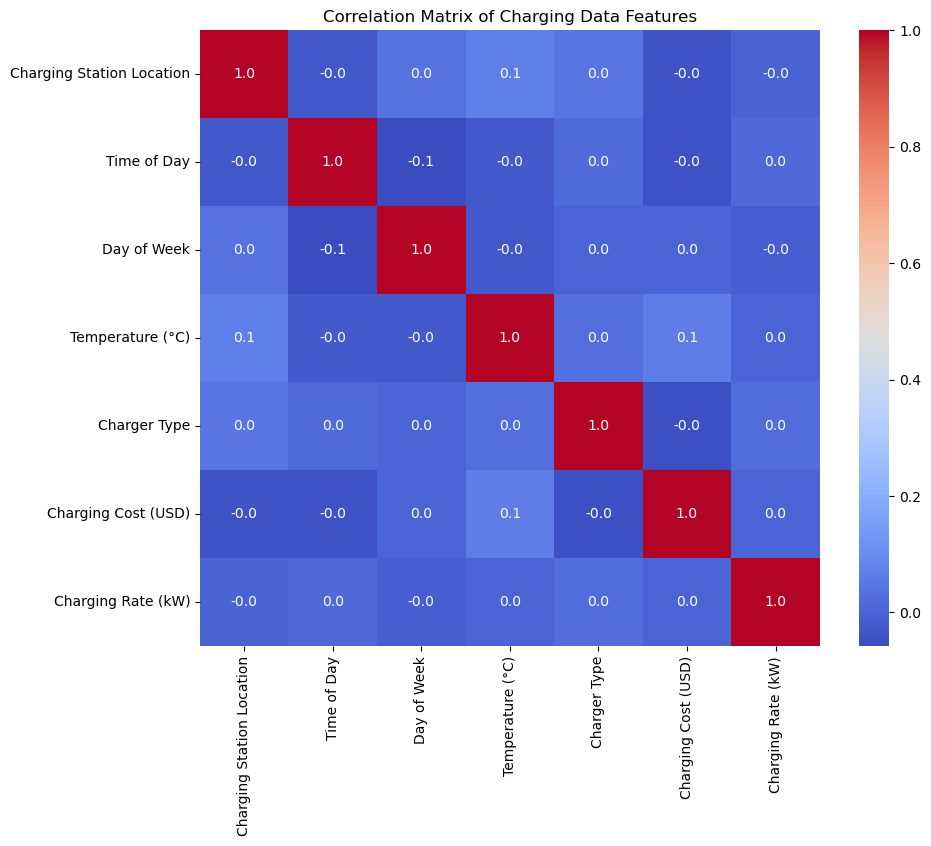

In [27]:
cols = ['Charging Station Location', 'Time of Day', 'Day of Week', 'Temperature (°C)', 'Charger Type', 'Charging Cost (USD)', 'Charging Rate (kW)']
d = data[cols].copy()

labels = {}

for col in ['Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']:
    le = LabelEncoder()
    d[col] = le.fit_transform(d[col])
    labels[col] = le

mat = d.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix of Charging Data Features")
plt.show()

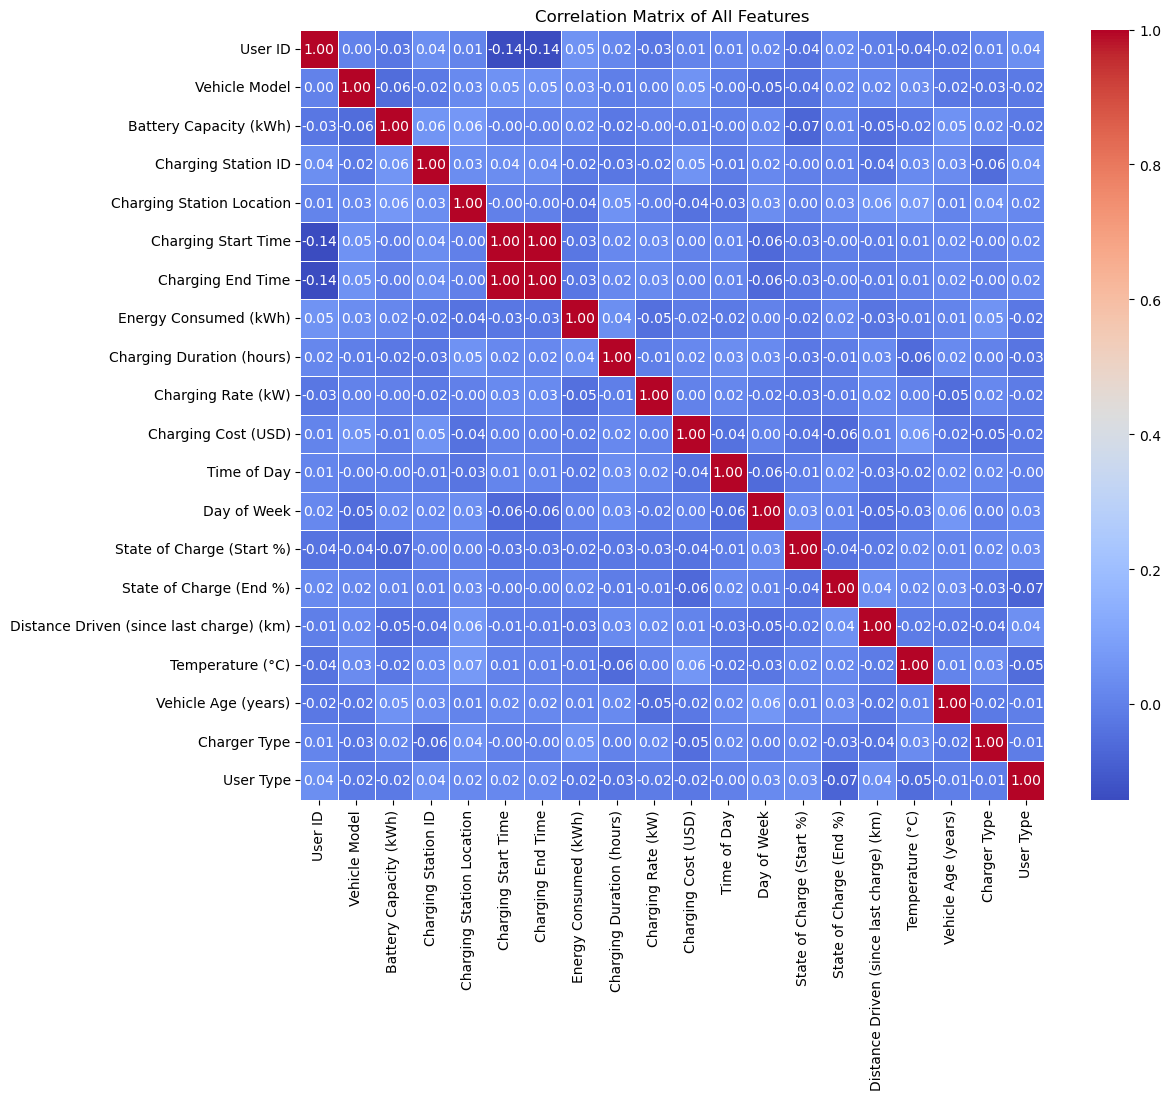

In [28]:
df = data.copy()
categorical_cols = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

mat = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.show()

In [87]:
enhanced_data = data.copy()
enhanced_data['cost_per_kwh'] = enhanced_data['Energy Consumed (kWh)'] / enhanced_data['Charging Cost (USD)']
enhanced_data['charged_rates_per_hour'] = (enhanced_data['State of Charge (End %)'] - enhanced_data['State of Charge (Start %)']) / enhanced_data['Charging Duration (hours)']
mean = enhanced_data['cost_per_kwh'].mean()
std = enhanced_data['cost_per_kwh'].std()

# filter
enhanced_data = enhanced_data[(enhanced_data['cost_per_kwh'] >= mean - 3 * std) & (enhanced_data['cost_per_kwh'] <= mean + 3 * std)]
print(f"original data count: {len(data)}, after filter: {len(enhanced_data)}")
print(enhanced_data['charged_rates_per_hour'][:10])

original data count: 1131, after filter: 1129
0    95.961948
1    23.789676
2    25.712165
3    13.032157
4     4.696010
5    -2.770940
6     2.837683
7     2.856490
8    34.505914
9    21.044185
Name: charged_rates_per_hour, dtype: float64


In [74]:
locaiton_charging_unit_price = enhanced_data.groupby('Charging Station Location')['cost_per_kwh'].apply(list)
locaiton_charging_unit_price

Charging Station Location
Chicago          [3.7006141233225076, 3.7047989987073398, 3.311...
Houston          [4.638879852067387, 6.0951494522899, 1.6593934...
Los Angeles      [1.931718728257224, 5.25350163796334, 1.342749...
New York         [1.4133871620101668, 1.7001622440220514, 1.782...
San Francisco    [0.5840123820319596, 0.5363145391545282, 1.170...
Name: cost_per_kwh, dtype: object

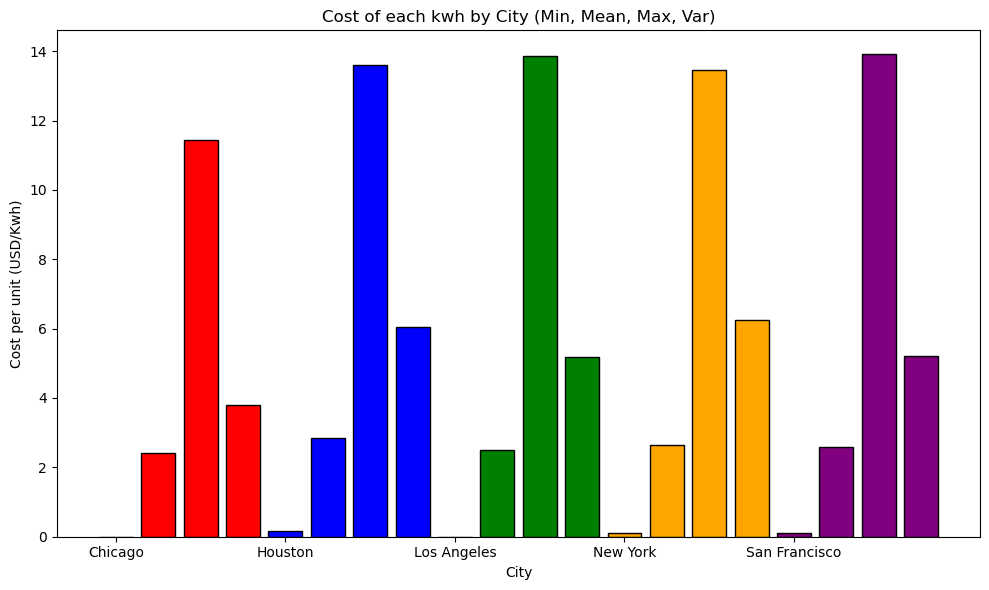

In [85]:
compare_charging_data = []
cities = list(locaiton_charging_unit_price.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = locaiton_charging_unit_price[city]
    var = np.var(rates)
    compare_charging_data.extend([np.min(rates), np.mean(rates), np.max(rates), var])
    city_labels.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Cost of each kwh by City (Min, Mean, Max, Var)')
plt.xlabel('City')
plt.ylabel('Cost per unit (USD/Kwh)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

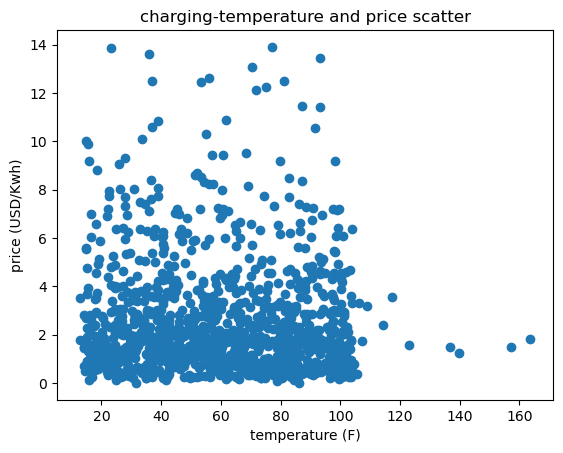

In [78]:
temperature_filtered_F = enhanced_data['Temperature (°C)']* 9/5 +32
plt.scatter(temperature_filtered_F, enhanced_data['cost_per_kwh'])

# 添加标题和坐标轴标签
plt.title('charging-temperature and price scatter')
plt.xlabel('temperature (F)')
plt.ylabel('price (USD/Kwh)')

# 显示图形
plt.show()

In [95]:
np.mean(enhanced_data['charged_rates_per_hour'])
negative_charger = enhanced_data[enhanced_data['charged_rates_per_hour'] < 0]
positive_charger = enhanced_data[enhanced_data['charged_rates_per_hour'] >= 0]
print(f"Original average of charging rates per hour: {np.mean(enhanced_data['charged_rates_per_hour'])}")
print(f"Average of negative chargers: {np.mean(negative_charger['charged_rates_per_hour'])} Count: {len(negative_charger)}")
print(f"Average of positive chargers: {np.mean(positive_charger['charged_rates_per_hour'])} Count: {len(positive_charger)}")

Original average of charging rates per hour: 15.328978615551835
Average of negative chargers: -9.505282960113266 Count: 238
Average of positive chargers: 21.962597308041502 Count: 891


In [94]:
negative_charger['Charging Station Location'].value_counts()

Los Angeles      64
Houston          50
New York         45
San Francisco    41
Chicago          38
Name: Charging Station Location, dtype: int64

In [96]:
mean = positive_charger['charged_rates_per_hour'].mean()
std = positive_charger['charged_rates_per_hour'].std()

# filter
filtered_positive_data = positive_charger[(positive_charger['charged_rates_per_hour'] >= mean - 3 * std) & (positive_charger['charged_rates_per_hour'] <= mean + 3 * std)]

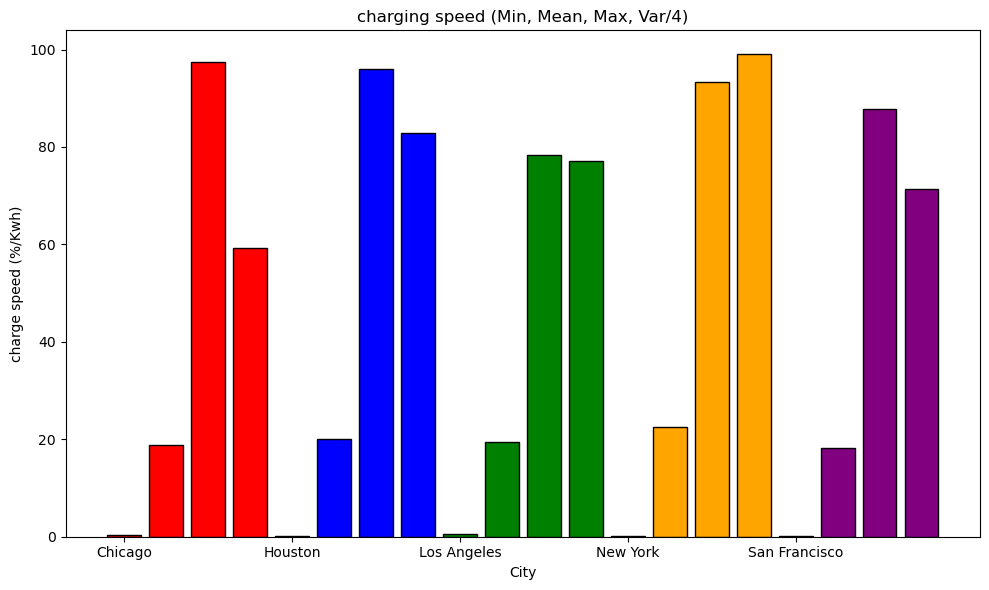

In [100]:
location_charging_unit_speed = filtered_positive_data.groupby('Charging Station Location')['charged_rates_per_hour'].apply(list)
compare_charging_data = []
cities = list(location_charging_unit_speed.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = location_charging_unit_speed[city]
    var = np.var(rates)/4
    compare_charging_data.extend([np.min(rates), np.mean(rates), np.max(rates), var])
    city_labels.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('charging speed (Min, Mean, Max, Var/4)')
plt.xlabel('City')
plt.ylabel('charge speed (%/Kwh)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

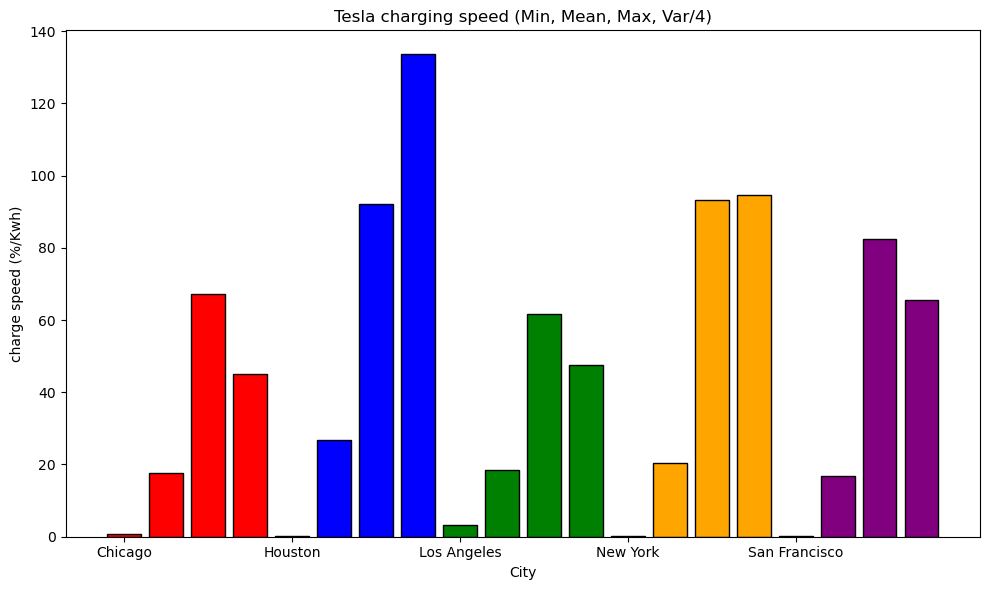

In [102]:
Tesla_data = filtered_positive_data[filtered_positive_data['Vehicle Model'] == "Tesla Model 3"]
location_charging_unit_speed = Tesla_data.groupby('Charging Station Location')['charged_rates_per_hour'].apply(list)
compare_charging_data = []
cities = list(location_charging_unit_speed.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = location_charging_unit_speed[city]
    var = np.var(rates)/4
    compare_charging_data.extend([np.min(rates), np.mean(rates), np.max(rates), var])
    city_labels.extend([city] * 4)

plt.figure(figsize=(10, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 4: (i + 1) * 4]
    plt.bar(city_position, compare_charging_data[i * 4:(i + 1) * 4], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Tesla charging speed (Min, Mean, Max, Var/4)')
plt.xlabel('City')
plt.ylabel('charge speed (%/Kwh)')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 4), labels=cities, rotation=0)
plt.tight_layout()
plt.show()